In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

def sim_anova_power(means_by_group, sigma, n_per_group, alpha=0.05, n_sims=2000, seed=0):
    """
    means_by_group: dict mapping group_label -> mean_lum (e.g. {'No CAR-T':10000, 'CAR1':6000, ...})
    sigma: common sd (biological)
    n_per_group: int (biological replicates per group)
    returns estimated power (fraction of sims where one-way ANOVA returns p < alpha)
    """
    rng = np.random.default_rng(seed)
    group_labels = list(means_by_group.keys())
    k = len(group_labels)
    sig_count = 0
    for sim in range(n_sims):
        rows = []
        for g in group_labels:
            mu = means_by_group[g]
            # simulate n_per_group biological replicates, each with e.g. 3 technical wells averaged:
            # optionally simulate technical noise, but here we assume n_per_group are final values
            samples = rng.normal(loc=mu, scale=sigma, size=n_per_group)
            for s in samples:
                rows.append((g, s))
        df = pd.DataFrame(rows, columns=['group','value'])
        model = ols('value ~ C(group)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        pval = anova_table['PR(>F)']['C(group)']
        if pval < alpha:
            sig_count += 1
    return sig_count / n_sims

# Example usage
means = {'No CAR-T':10000, 'Non-transduced':9200, 'Non-targeting':8800, 'CAR-A':6000, 'CAR-B':5000}
sigma = 1500   # between-run biological SD
for n in [2,3,4,5,8]:
    pwr = sim_anova_power(means, sigma, n_per_group=n, alpha=0.05, n_sims=1000, seed=42)
    print(f"n_per_group={n}, estimated power ≈ {pwr:.2f}")


n_per_group=2, estimated power ≈ 0.54
n_per_group=3, estimated power ≈ 0.91
n_per_group=4, estimated power ≈ 0.99
n_per_group=5, estimated power ≈ 1.00
n_per_group=8, estimated power ≈ 1.00


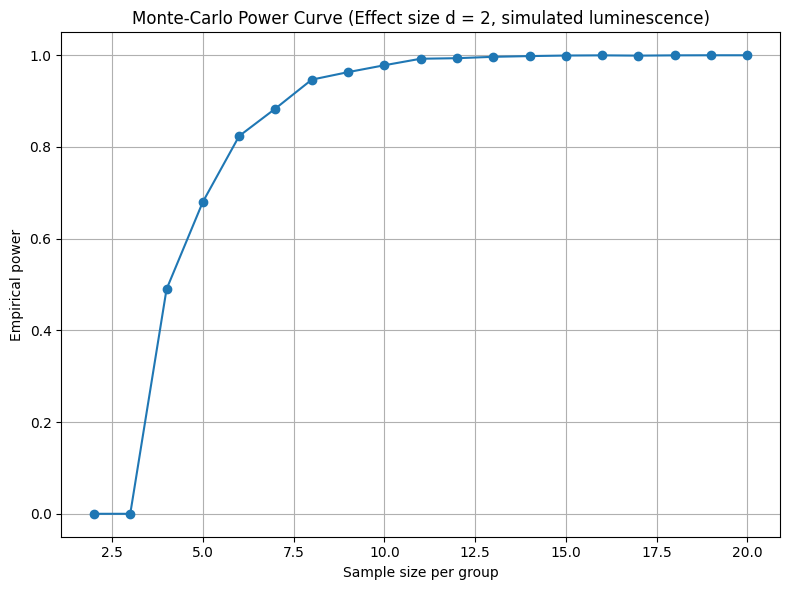

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ----------------------------------------------------------
# Parameters for luminescence simulation
# ----------------------------------------------------------

# Effect size d = 2 → mean difference = 2 * sd
sd = 10000
mean_control = 100000
mean_treatment = mean_control - 2 * sd   # 80,000 RLU

sample_sizes = range(2, 21)   # n per group
n_sims = 5000                  # number of Monte-Carlo repetitions

empirical_power = []

# ----------------------------------------------------------
# Monte-Carlo simulation using Mann–Whitney U test
# ----------------------------------------------------------

for n in sample_sizes:
    sig_count = 0

    for _ in range(n_sims):
        # Simulate luminescence values (normal noise, but test is nonparametric)
        control = np.random.normal(mean_control, sd, n)
        treatment = np.random.normal(mean_treatment, sd, n)

        # Mann–Whitney U (two-sided)
        p = mannwhitneyu(control, treatment, alternative='two-sided').pvalue

        if p < 0.05:
            sig_count += 1

    empirical_power.append(sig_count / n_sims)

# ----------------------------------------------------------
# Plot the power curve
# ----------------------------------------------------------

plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, empirical_power, marker='o')
plt.xlabel("Sample size per group")
plt.ylabel("Empirical power")
plt.title("Monte-Carlo Power Curve (Effect size d = 2, simulated luminescence)")
plt.grid(True)
plt.tight_layout()

plt.show()
